In [1]:
from time import time
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
np.random.seed(42)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression,  f_classif

from sklearn.linear_model import LinearRegression, Ridge,  Lasso, SGDRegressor, ElasticNet, Lars, OrthogonalMatchingPursuit,\
                                 BayesianRidge, ARDRegression, HuberRegressor, RANSACRegressor, PassiveAggressiveRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

In [2]:
import pycaret
pycaret.__version__

'3.1.0'

In [3]:
from pycaret.regression import *

**Conclusions** | [Final Modeling Notebook](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/18.3_Modeling_final.ipynb)

 - see bottom of notebook for summary table and graphs
 - with model-specific preprocessing and hyperparameter tuning, `CatBoost` and `GradientBoostingRegressor` outperform other models by a comfortable margin
   - `CatBoost` outperforms all other models by all metrics, `GradientBoostingRegressor` typically 2nd place
   - `k-Nearest-Neighbors` provides compelling results, 2nd best MAPE
   - other models show improvement with tuning, but still lag behind top three
 - briefly explored possibility of improving top two models by blending/stacking, will evaluate further in final notebook
   - due to differences in feature selection, will not progress `k-Nearest-Neighbors` model

---

**Data Load, Split**
 - utilizing entire dataset with cross-validation for model selection

In [5]:
data = pd.read_parquet(Path('data/game_stats.parquet'))
X = data.iloc[:,6:-2]
y1 = data['home_margin'] # target for regression
y2 = data['home_win'] # target for classification

(1216, 12)
(305, 12)



   - all data, normalized. `n_iter=45`
     - `catboost, extra trees, lightGBM, GBR, XGB`
   - select 7-8 features, test scaled and unscaled, except for those listed below. `n_iter=120`
     - `kNN, lin reg, ridge, lar, llar, kernel ridge, bayesian ridge, ARD, SGD`
       - **never scaled:** kNN, kernel ridge, llar, *bayesian ridge*\* 
         - \**forgot to exclude this one*
       - **never unscaled:** SGD

In [49]:
%%time
s1 = setup(pd.concat([X, y1], axis=1), target = 'home_margin', session_id = 42,
           train_size=0.75, verbose=False, normalize=True)

s1_list = ['catboost','et','lightgbm','xgboost','gbr']
s1_models = []
for model in s1_list:   
    m = create_model(model, verbose=False)
    print('created', m.__class__.__name__)
    if model == 'catboost':
        s1_models.append(m)
    else:
        s1_models.append(tune_model(m, n_iter=45, verbose=False))
        print('tuned', m.__class__.__name__)

s1_models = compare_models(include=s1_models, n_select=len(s1_models))
s1_results = pull()

created CatBoostRegressor
created ExtraTreesRegressor
tuned ExtraTreesRegressor
created LGBMRegressor
tuned LGBMRegressor
created XGBRegressor
tuned XGBRegressor
created GradientBoostingRegressor
tuned GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,1.5644,6.4476,2.4955,0.8877,0.4167,0.4867,0.6950
4,Gradient Boosting Regressor,1.6742,6.8249,2.5817,0.8808,0.4213,0.5349,0.0510
3,Extreme Gradient Boosting,1.7532,7.2142,2.6526,0.8738,0.4365,0.5408,0.1220
2,Light Gradient Boosting Machine,1.7562,7.2576,2.6654,0.8736,0.4398,0.5449,0.0740
1,Extra Trees Regressor,1.7867,7.2726,2.6639,0.8731,0.4303,0.5662,0.0680


CPU times: total: 1min 8s
Wall time: 2min 31s


In [50]:
s1_results.loc[:,'study'] = 'all features, normalized'

In [51]:
s1_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),study
0,CatBoost Regressor,1.5644,6.4476,2.4955,0.8877,0.4167,0.4867,0.695,"all features, normalized"
4,Gradient Boosting Regressor,1.6742,6.8249,2.5817,0.8808,0.4213,0.5349,0.051,"all features, normalized"
3,Extreme Gradient Boosting,1.7532,7.2142,2.6526,0.8738,0.4365,0.5408,0.122,"all features, normalized"
2,Light Gradient Boosting Machine,1.7562,7.2576,2.6654,0.8736,0.4398,0.5449,0.074,"all features, normalized"
1,Extra Trees Regressor,1.7867,7.2726,2.6639,0.8731,0.4303,0.5662,0.068,"all features, normalized"


---

   - select 7-8 features, test scaled and unscaled, except for those listed below. `n_iter=150`
     - `kNN, lin reg, ridge, lar, kernel ridge, bayesian ridge, ARD`
       - never scaled: kNN, kernel ridge, llar
       - never unscaled: SGD

In [66]:
studies = {
    '8 features, unscaled': (8, False, ['knn','kr','llar','lr','ridge','lar','br','ard']),
    '8 features, scaled': (8, True, ['lr','ridge','lar','br','ard', SGDRegressor()]),
    '7 features, unscaled': (7, False, ['knn','kr','llar','lr','ridge','lar','br','ard']),
    '7 features, scaled': (7, True, ['lr','ridge','lar','br','ard', SGDRegressor()]),
}
s2_results = {}

**Tuning Grid for RandomizedSearchCV, SGD not in PyCaret library**

[visualize distributions](https://nbpub.pythonanywhere.com/)

In [59]:
from scipy.stats import loguniform, powerlaw

In [60]:
SGD_grid = { 
    # leave loss function, penalty, learning_rate, fit_intercept at defaults: 'squared_error', 'L2', 'invscaling', True
    # vary alpha, tol(erance), eta0, power_t
    'alpha': loguniform(8e-5, 1e-2, 0, 1), # def=1e-4, float | higher values increase regularization strength
    'tol': loguniform(1e-4, 1e-2, 0, 1), # def=1e-3, float or None | convergence parameter
    'eta0': loguniform(5e-4, 5e-1, 0, 1), # def=0.01, float | initial learning rate
    'power_t': powerlaw(0.6, 0, 1), # def=0.25, float | exponent for invscaling learning rate: eta = eta0/pow(t, power_t)
}

In [68]:
%%time

for study, cond in studies.items():
    print('performing', study)
    s = setup(pd.concat([X, y1], axis=1), target = 'home_margin', session_id = 42, train_size=0.75,
              feature_selection=True, feature_selection_method='univariate', n_features_to_select=cond[0],
              normalize=cond[1], verbose=False)
    models = []
    for model in cond[2]:
        m = create_model(model, verbose=False)
        if type(model) == str:
            models.append(tune_model(m,n_iter=120, verbose=False))
        else:
            models.append(tune_model(m, custom_grid = SGD_grid, n_iter=120, verbose=False))
        
    _ = compare_models(include=models)
    s2_results[study] = pull()
    s2_results[study].loc[:,'study'] = study 

performing 8 features, unscaled


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,K Neighbors Regressor,1.6968,7.2630,2.6506,0.8727,0.4121,0.5069,0.0140
4,Ridge Regression,1.7156,7.7994,2.7542,0.8635,0.4306,0.5452,0.0080
3,Linear Regression,1.7192,7.8020,2.7569,0.8634,0.4347,0.5487,0.0090
1,Kernel Ridge,1.7175,7.8072,2.7548,0.8633,0.4312,0.5467,0.0160
2,Lasso Least Angle Regression,1.7174,7.8090,2.7555,0.8633,0.4308,0.5465,0.0090
5,Least Angle Regression,1.7161,7.8115,2.7585,0.8633,0.4321,0.5445,0.0120
7,Automatic Relevance Determination,1.7217,7.8101,2.7559,0.8633,0.4317,0.5477,0.0100
6,Bayesian Ridge,1.7265,7.8475,2.7621,0.8626,0.4335,0.5493,0.0100


performing 8 features, scaled


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
1,Ridge Regression,1.7346,7.8001,2.7575,0.8635,0.4374,0.5474,0.0100
0,Linear Regression,1.7198,7.8057,2.7572,0.8633,0.4352,0.5465,0.0100
2,Least Angle Regression,1.7161,7.8115,2.7585,0.8633,0.4321,0.5445,0.0110
3,Bayesian Ridge,1.7188,7.8097,2.7583,0.8633,0.4328,0.5449,0.0110
4,Automatic Relevance Determination,1.7199,7.8094,2.7581,0.8633,0.4329,0.5456,0.0110
5,SGDRegressor,1.7195,7.8316,2.7622,0.8629,0.4321,0.5443,0.0110


performing 7 features, unscaled


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,K Neighbors Regressor,1.6958,7.2545,2.6486,0.8729,0.4112,0.5068,0.0160
3,Linear Regression,1.7184,7.8017,2.7545,0.8634,0.4319,0.5469,0.0090
4,Ridge Regression,1.7153,7.8021,2.7552,0.8634,0.4309,0.5449,0.0090
1,Kernel Ridge,1.7178,7.8084,2.7550,0.8633,0.4313,0.5470,0.0170
2,Lasso Least Angle Regression,1.7174,7.8090,2.7555,0.8633,0.4308,0.5465,0.0100
5,Least Angle Regression,1.7161,7.8115,2.7585,0.8633,0.4321,0.5445,0.0090
7,Automatic Relevance Determination,1.7217,7.8102,2.7559,0.8633,0.4317,0.5477,0.0090
6,Bayesian Ridge,1.7249,7.8460,2.7620,0.8626,0.4333,0.5483,0.0090


performing 7 features, scaled


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
1,Ridge Regression,1.7344,7.7968,2.7566,0.8635,0.4369,0.5474,0.0100
5,SGDRegressor,1.7165,7.7969,2.7553,0.8635,0.4335,0.5472,0.0120
2,Least Angle Regression,1.7161,7.8115,2.7585,0.8633,0.4321,0.5445,0.0100
3,Bayesian Ridge,1.7186,7.8090,2.7581,0.8633,0.4327,0.5449,0.0100
4,Automatic Relevance Determination,1.7223,7.8092,2.7580,0.8633,0.4335,0.5465,0.0140
0,Linear Regression,1.7161,7.8136,2.7587,0.8632,0.4330,0.5446,0.0130


CPU times: total: 1min 45s
Wall time: 2min 39s


In [122]:
print('study two without kNN')
display(results[~results.Model.isin(s1_results.Model.unique())].drop(index=[0,14])
            .sort_values(['R2','RMSE','MAE'],ascending=[False, True, True]).style\
        .background_gradient(subset=['R2'], cmap='viridis')
        .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
        .highlight_max(subset=['R2'],  props='font-weight:bold')
        .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
        .format('{:.4f}', subset=results.columns[1:7]))

study two without kNN


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),study
1,Ridge Regression,1.7156,7.7994,2.7542,0.8635,0.4306,0.5452,0.008000,"8 features, unscaled"
23,SGDRegressor,1.7165,7.7969,2.7553,0.8635,0.4335,0.5472,0.012000,"7 features, scaled"
22,Ridge Regression,1.7344,7.7968,2.7566,0.8635,0.4369,0.5474,0.010000,"7 features, scaled"
8,Ridge Regression,1.7346,7.8001,2.7575,0.8635,0.4374,0.5474,0.010000,"8 features, scaled"
15,Linear Regression,1.7184,7.8017,2.7545,0.8634,0.4319,0.5469,0.009000,"7 features, unscaled"
16,Ridge Regression,1.7153,7.8021,2.7552,0.8634,0.4309,0.5449,0.009000,"7 features, unscaled"
2,Linear Regression,1.7192,7.8020,2.7569,0.8634,0.4347,0.5487,0.009000,"8 features, unscaled"
3,Kernel Ridge,1.7175,7.8072,2.7548,0.8633,0.4312,0.5467,0.016000,"8 features, unscaled"
17,Kernel Ridge,1.7178,7.8084,2.7550,0.8633,0.4313,0.5470,0.017000,"7 features, unscaled"
4,Lasso Least Angle Regression,1.7174,7.8090,2.7555,0.8633,0.4308,0.5465,0.009000,"8 features, unscaled"


---

In [79]:
tables = [s2_results[key] for key in s2_results.keys()]
tables.append(s1_results)
results = pd.concat(tables).reset_index(drop=True)

In [117]:
display(results.sort_values(['R2','RMSE','MAE'],ascending=[False, True, True]).style\
        .background_gradient(subset=['R2'], cmap='viridis')
        .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
        .highlight_max(subset=['R2'],  props='font-weight:bold')
        .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
        .format('{:.4f}', subset=results.columns[1:7]))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),study
28,CatBoost Regressor,1.5644,6.4476,2.4955,0.8877,0.4167,0.4867,0.695000,"all features, normalized"
29,Gradient Boosting Regressor,1.6742,6.8249,2.5817,0.8808,0.4213,0.5349,0.051000,"all features, normalized"
30,Extreme Gradient Boosting,1.7532,7.2142,2.6526,0.8738,0.4365,0.5408,0.122000,"all features, normalized"
31,Light Gradient Boosting Machine,1.7562,7.2576,2.6654,0.8736,0.4398,0.5449,0.074000,"all features, normalized"
32,Extra Trees Regressor,1.7867,7.2726,2.6639,0.8731,0.4303,0.5662,0.068000,"all features, normalized"
14,K Neighbors Regressor,1.6958,7.2545,2.6486,0.8729,0.4112,0.5068,0.016000,"7 features, unscaled"
0,K Neighbors Regressor,1.6968,7.2630,2.6506,0.8727,0.4121,0.5069,0.014000,"8 features, unscaled"
1,Ridge Regression,1.7156,7.7994,2.7542,0.8635,0.4306,0.5452,0.008000,"8 features, unscaled"
23,SGDRegressor,1.7165,7.7969,2.7553,0.8635,0.4335,0.5472,0.012000,"7 features, scaled"
22,Ridge Regression,1.7344,7.7968,2.7566,0.8635,0.4369,0.5474,0.010000,"7 features, scaled"


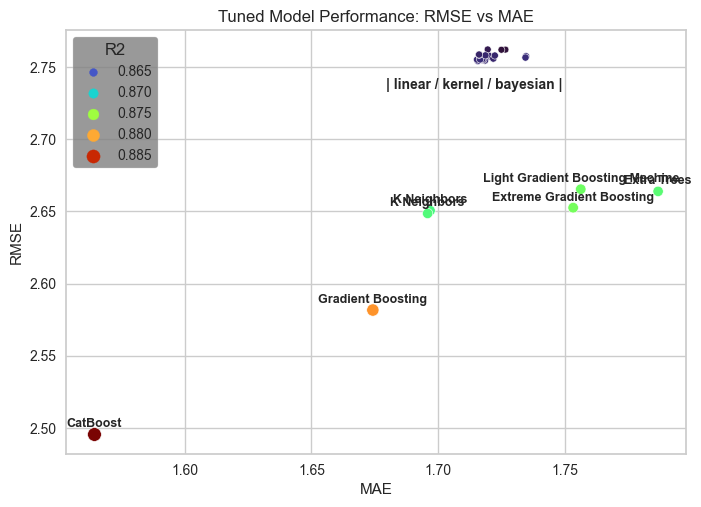

In [113]:
m1 = 'MAE'
m2 = 'RMSE'
sns.scatterplot(results, x=m1, y=m2, hue='R2', 
                palette='turbo', size='R2')
for val in results.sort_values([m2]).head(7).index:
    plt.text(results.loc[val,m1], results.loc[val,m2]+.005,
             results.loc[val,'Model'].replace(' Regressor',''),
             fontsize=9, fontweight='bold', ha='center')

plt.text(results[m1].max()*0.94, results[m2].max()*.99, '| linear / kernel / bayesian |', fontsize=10, fontweight='bold')

plt.legend(loc='upper left', title='R2', frameon=True, facecolor='grey')    
plt.title(f'Tuned Model Performance: {m2} vs {m1}')
plt.savefig(f'graphs/PreProc/model-selection_{m2}-vs-{m1}.png', bbox_inches='tight')
plt.show()

#### Model Blending
- can models from different studies be blended???
  - kNN with 7 features, but CatBoost+GBR with all features+scaled?

In [114]:
s1_models

 GradientBoostingRegressor(learning_rate=0.05, max_depth=10, max_features=1.0,
                           min_impurity_decrease=0.001, min_samples_leaf=3,
                           min_samples_split=4, n_estimators=130,
                           random_state=42, subsample=0.2),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=190,
              n_jobs=-1, num_parallel_tree=None, random_s

In [51]:
%%time
for val in [2,3]:
    boost_blend = blend_models(s1_models[0:val])
    boost_results = pull().loc['Mean',:]
    results.loc[results.index.max()+1, 'Model'] = f'Top {val} Blend'
    results.loc[results.index.max(), 'study'] = f'ensemble blending'
    results.loc[results.index.max(),boost_results.index] = boost_results

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4254,4.1294,2.0321,0.9235,0.3976,0.5085
1,1.8195,9.3687,3.0608,0.8515,0.4671,0.4329
2,1.5147,4.3666,2.0896,0.9247,0.3619,0.3922
3,1.6533,6.9830,2.6425,0.8722,0.4416,0.5049
4,1.7519,6.2888,2.5078,0.9071,0.4566,0.5781
5,1.4678,4.1746,2.0432,0.9219,0.4024,0.5263
6,1.8705,9.8285,3.1350,0.8107,0.4410,0.6431
7,1.4653,5.1626,2.2721,0.8921,0.3671,0.4517
8,1.7189,9.1298,3.0216,0.8553,0.4158,0.5064


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5196,4.5890,2.1422,0.9150,0.3977,0.5306
1,1.8955,9.7848,3.1281,0.8449,0.4923,0.4430
2,1.5497,4.3760,2.0919,0.9245,0.3829,0.4131
3,1.7089,7.2950,2.7009,0.8665,0.4802,0.5240
4,1.7613,6.2344,2.4969,0.9079,0.4547,0.5885
5,1.4805,4.0888,2.0221,0.9235,0.4066,0.5265
6,1.9149,10.3642,3.2194,0.8004,0.4482,0.6507
7,1.4994,5.4473,2.3339,0.8861,0.3974,0.4580
8,1.6862,9.1114,3.0185,0.8556,0.4214,0.4889


CPU times: total: 1.48 s
Wall time: 11.8 s


In [53]:
results.loc[12:,'study_time (S/model)'] = 6

In [54]:
results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),study,study_time (S/model)
0,CatBoost Regressor,1.5644,6.4476,2.4955,0.8877,0.4167,0.4867,0.614,"all features, normalized",27.0
1,Gradient Boosting Regressor,1.6742,6.8249,2.5817,0.8808,0.4213,0.5349,0.047,"all features, normalized",27.0
2,Extreme Gradient Boosting,1.7532,7.2142,2.6526,0.8738,0.4365,0.5408,0.108,"all features, normalized",27.0
3,Light Gradient Boosting Machine,1.7562,7.2576,2.6654,0.8736,0.4398,0.5449,0.064,"all features, normalized",27.0
4,Extra Trees Regressor,1.7867,7.2726,2.6639,0.8731,0.4303,0.5662,0.060,"all features, normalized",27.0
5,K Neighbors Regressor,1.6968,7.2630,2.6506,0.8727,0.4121,0.5069,0.012,"8 features, unscaled",3.6
6,Ridge Regression,1.7156,7.7994,2.7542,0.8635,0.4306,0.5452,0.010,"8 features, unscaled",3.6
7,Linear Regression,1.7192,7.8020,2.7569,0.8634,0.4347,0.5487,0.010,"8 features, unscaled",3.6
8,Least Angle Regression,1.7161,7.8115,2.7585,0.8633,0.4321,0.5445,0.009,"8 features, unscaled",3.6
9,Kernel Ridge,1.7175,7.8072,2.7548,0.8633,0.4312,0.5467,0.016,"8 features, unscaled",3.6


*Previous*

In [70]:
s1_models[0:2]

 GradientBoostingRegressor(learning_rate=0.05, max_depth=10, max_features=1.0,
                           min_impurity_decrease=0.001, min_samples_leaf=3,
                           min_samples_split=4, n_estimators=130,
                           random_state=42, subsample=0.2)]

In [72]:
boost_results = pull()

In [81]:
boost_results = boost_results.loc['Mean',:]

In [77]:
results.loc[12, 'Model'] = 'Cat-GBR Voting Blend'
results.loc[12, 'Model'] = 'blending test'

In [84]:
results.loc[12,boost_results.index] = boost_results

In [85]:
results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),study,study_time (S/model)
0,CatBoost Regressor,1.5644,6.4476,2.4955,0.8877,0.4167,0.4867,0.584,"all features, unscaled",18.0
1,Gradient Boosting Regressor,1.6742,6.8249,2.5817,0.8808,0.4213,0.5349,0.048,"all features, unscaled",18.0
2,Extreme Gradient Boosting,1.7532,7.2142,2.6526,0.8738,0.4365,0.5408,0.106,"all features, unscaled",18.0
3,Light Gradient Boosting Machine,1.7562,7.2576,2.6654,0.8736,0.4398,0.5449,0.065,"all features, unscaled",18.0
4,Extra Trees Regressor,1.7867,7.2726,2.6639,0.8731,0.4303,0.5662,0.064,"all features, unscaled",18.0
5,K Neighbors Regressor,1.6968,7.2630,2.6506,0.8727,0.4121,0.5069,0.012,"8 features, unscaled",2.3
6,Ridge Regression,1.7156,7.7994,2.7542,0.8635,0.4306,0.5452,0.010,"8 features, unscaled",2.3
7,Linear Regression,1.7192,7.8020,2.7569,0.8634,0.4347,0.5487,0.009,"8 features, unscaled",2.3
8,Least Angle Regression,1.7161,7.8115,2.7585,0.8633,0.4321,0.5445,0.010,"8 features, unscaled",2.3
9,Kernel Ridge,1.7175,7.8072,2.7548,0.8633,0.4312,0.5467,0.017,"8 features, unscaled",2.3


In [89]:
boost_blend

VotingRegressor(estimators=[('CatBoost Regressor',
                             <catboost.core.CatBoostRegressor object at 0x000001A75BD273A0>),
                            ('Gradient Boosting Regressor',
                             GradientBoostingRegressor(learning_rate=0.05,
                                                       max_depth=10,
                                                       max_features=1.0,
                                                       min_impurity_decrease=0.001,
                                                       min_samples_leaf=3,
                                                       min_samples_split=4,
                                                       n_estimators=130,
                                                       random_state=42,
                                                       subsample=0.2))],
                n_jobs=-1)